[[Uncomplte]]

In this notebook we are going to use a simple Convolution neural net to classify a [FashionMNIST Dataset](https://www.kaggle.com/zalando-research/fashionmnist).


Using a max-pooling layer will help us to reduce the size of output activation map. Using a max pooling means we will use a filter or kernel of size 2x2 or 3x3... on every subimages of same size. If we have a 2x2 filter and 2x2 sub-image then there will be single output value for that sub-image which will be the maximum value of sub-image image. i.e if sub-image is [[2,3],[4,5]] the output pixel would be 5. The mechanism of convolution and max-pooling are very similar But unlike convolution there will be no value in the filter instead the output are determined by using some calculation like maximum() or average() in max-pooling



For more details on backpropagating while Max Pool:

[https://datascience.stackexchange.com/questions/11699/backprop-through-max-pooling-layers](https://datascience.stackexchange.com/questions/11699/backprop-through-max-pooling-layers)

For more details on CNN:


[Convolutions and Backpropagations - Pavithra Solai](https://medium.com/@pavisj/convolutions-and-backpropagations-46026a8f5d2c)

[Why do we rotate weights when computing the gradients in a convolution layer of a convolution network?](http://soumith.ch/ex/pages/2014/08/07/why-rotate-weights-convolution-gradient/)

[A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)

[https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721)

In [123]:
## Import necessary Packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1)

In [124]:
## Read FashionMNIST Dataset
dataframe = pd.read_csv("fashion-mnist_train.csv")

## Just using 700 images
data = dataframe.values[:400]

## Split labels and images
labels = data[:, 0]
images = data[:, 1:]

## Normalize the image
images = images/255

## Splitting Training and Testing Set
train_test_split = 0.80
train_test_split_index = int(len(images) * train_test_split)
training_images = images[:train_test_split_index ]
testing_images = images[train_test_split_index: ]

## One-hot encoding the labels

one_hot_labels = []
for label in labels:
    base_label = np.zeros(10)
    base_label[int(label)] = 1
    one_hot_labels.append(base_label)

labels = np.array(one_hot_labels)
training_labels = labels[:train_test_split_index]
testing_labels = labels[train_test_split_index: ]

assert(len(training_images) == len(training_labels))
assert(len(testing_images) == len(testing_labels))

print(len(training_images))
print(len(testing_images))

320
80


In [125]:
## Labels name
index_to_label_name = {
    0: "t-shirt", 1: "trousers", 2: "pullover", 3: "dress", 4: "coat", 5: "sandal", 6: "shirt", 7: "sneaker",
    8: "bag", 9: "ankle boot"
}

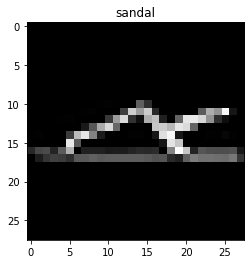

In [126]:
## Sample Training Image with label

img = training_images[7].reshape((28,28))
label = index_to_label_name[np.argmax(training_labels[7])]
plt.title(label)
plt.imshow(img, cmap="gray")

In [127]:
## Initialize weights

input_image_height = input_image_width = 28
input_image_depth = 1

kernel_1_width = kernel_1_height = 3
kernel_1_count = 16
kernel_1_depth = input_image_depth

kernel_1 = 0.2 * np.random.random((kernel_1_count , kernel_1_depth, kernel_1_height, kernel_1_width)) - 0.1

layer_1_output_size = input_image_height - kernel_1_height + 1



max_pool_size = 2
stride=2
layer_2_output_size = ((layer_1_output_size - max_pool_size)//stride) + 1
layer_3_size = 100

weight_layer_2_layer_3 = 0.2 * np.random.random(
    (kernel_1_count*layer_2_output_size*layer_2_output_size, layer_3_size)) - 0.1

output_size = 10
weight_layer_3_output = 0.2 * np.random.random((layer_3_size, output_size)) - 0.1

In [128]:
## Activation Function
def tanh(x):
    return np.tanh(x)

def tanh2deriv(output):
    return (1 - output**2)

def softmax(x):
    temp = np.exp(x)
    return temp/np.sum(temp, axis=1, keepdims=True)

In [129]:
## Forward Convolution
## Takes input, kernel and returns output activation map
def convolution(input_tensor, kernel):
    kernel_height = kernel.shape[2]
    kernel_width = kernel.shape[3]
    output_tensor_height = input_tensor.shape[1] - kernel_height + 1
    output_tensor_width = input_tensor.shape[2] - kernel_width + 1
    
    output = list()
    
    for kernel_count_idx in range(kernel.shape[0]):
        select_kernel = kernel[kernel_count_idx]
        
        for row in range(output_tensor_height):
            for col in range(output_tensor_width):
                sum_kernel_sect = 0
                for didx in range(input_tensor.shape[0]):
                    sect = input_tensor[didx, row:row+kernel.shape[2], col:col+kernel.shape[3]]
            
                    sum_kernel_sect += np.sum(sect.dot(select_kernel[didx]))
                output.append(sum_kernel_sect)                 

    output = np.array(output)
    output = tanh(output)
    output = output.reshape((kernel.shape[0],output_tensor_height, output_tensor_width))
    
    
    
    return output             

In [130]:
## Calculates delta for the kernels
## Takes deltas, previous layer and kernel in-between and returns deltas for kernel
def weight_delta_convolution(input_tensor, delta_kernel_output, kernel):
    delta_kernel = np.empty_like(kernel)
    
    for delta_kernel_output_idx in range(delta_kernel_output.shape[0]):
        select_delta_kernel_output = delta_kernel_output[delta_kernel_output_idx]
        
        for row in range(input_tensor.shape[1] - select_delta_kernel_output.shape[0] + 1):
            for col in range(input_tensor.shape[2] - select_delta_kernel_output.shape[1] + 1):
                
                for input_tensor_idx in range(input_tensor.shape[0]):
                    sect = input_tensor[input_tensor_idx, row:row+select_delta_kernel_output.shape[0],
                                        col:col+select_delta_kernel_output.shape[1]]
                    delta_kernel[delta_kernel_output_idx, input_tensor_idx, row, col] = np.sum(
                        sect.dot(select_delta_kernel_output)
                    )
    return delta_kernel

In [131]:
def maxPool(input_tensor, max_pool_filter_size):
    output_tensor_height =  (input_tensor.shape[1] - max_pool_filter_size)//max_pool_filter_size + 1
    output_tensor_width = (input_tensor.shape[2] - max_pool_filter_size)//max_pool_filter_size + 1
    activation_map_depth = input_tensor.shape[0]
    
    output = np.zeros((activation_map_depth, output_tensor_height, output_tensor_width))
    
    input_tensor_1_0 = np.zeros_like(input_tensor)
        
    
    for map_idx in range(activation_map_depth):
        output_row = 0
        
        for row in range(0, input_tensor.shape[1] - max_pool_filter_size+1, 2):
            output_col = 0

            for col in range(0, input_tensor.shape[2] - max_pool_filter_size+1, 2):
                sect = input_tensor[map_idx, row:row+max_pool_filter_size, col:col+max_pool_filter_size]
                max_value = np.max(sect)
                
                output[map_idx, output_row, output_col] = max_value
                output_col = output_col + 1
                
                max_value_idx = np.unravel_index(sect.argmax(), sect.shape)
                
                input_tensor_1_0[map_idx, row+max_value_idx[0], col+max_value_idx[1]] = 1

                
                
            output_row = output_row + 1
                
    return output, input_tensor_1_0                
                

In [132]:
def maxPoolDelta(input_tensor_1_0, output_delta, max_pool_filter_size):
    input_delta = np.zeros_like(input_tensor_1_0)
    for map_idx in range(input_tensor_1_0.shape[0]):
        row_for_output_delta = 0
        for row in range(0, input_tensor_1_0.shape[1] - max_pool_filter_size+1, 2):
            col_for_output_delta = 0
            for col in range(0, input_tensor_1_0.shape[2] - max_pool_filter_size+1, 2):
                sect = input_tensor_1_0[map_idx, row:row+max_pool_filter_size, col:col+max_pool_filter_size]
                output_delta_sect = output_delta[map_idx, row_for_output_delta, col_for_output_delta]
                
                input_delta[map_idx, row:row+max_pool_filter_size, col:col+max_pool_filter_size] = sect * output_delta_sect
                
                col_for_output_delta += 1
            row_for_output_delta += 1
    return input_delta
            

In [133]:
num_iterations = 20
lr = 0.001
train_losses = list() ## For plotting train loss 
test_losses = list()

for itera in range(1, num_iterations+1):
    
    train_error = 0
    train_correct = 0
    
    for img_idx in range(len(training_images)):
        
        img = training_images[img_idx]
        label = training_labels[img_idx].reshape((10, 1))
        
        layer_0 = img.reshape((input_image_depth, input_image_height, input_image_width))
        
        layer_1 = convolution(layer_0, kernel_1)
        layer_2, layer_2_1_0 = maxPool(layer_1, max_pool_size)
        layer_2 = tanh(layer_2)
            
        layer_2_flattened = layer_2.reshape((-1, 1))
        
        layer_3 = tanh(weight_layer_2_layer_3.T.dot(layer_2_flattened))
        
#         layer_1_flattened = layer_1.reshape((-1, 1))
        
#         layer_2 = tanh(weight_layer_1_layer_2.T.dot(layer_1_flattened))
        
        final_output = weight_layer_3_output.T.dot(layer_3)
        ##.## Softmax
        train_error = train_error + np.sum((final_output - label)**2)
        train_correct = train_correct + int(np.argmax(final_output) == np.argmax(label))
        
        
        delta_final_output = final_output - label
        delta_layer_3 = weight_layer_3_output.dot(delta_final_output) * tanh2deriv(layer_3)
        delta_layer_2_flattened = weight_layer_2_layer_3.dot(delta_layer_3) * tanh2deriv(layer_2_flattened)
        delta_layer_2 = delta_layer_2_flattened.reshape(layer_2.shape)
        ##
        delta_layer_1 = maxPoolDelta(layer_2_1_0, delta_layer_2, 2)
        
        weight_layer_3_output = weight_layer_3_output - lr * layer_3.dot(delta_final_output.T)
        weight_layer_2_layer_3 = weight_layer_2_layer_3 - lr * layer_2_flattened.dot(delta_layer_3.T)
        
        kernel_1 = kernel_1 - lr * weight_delta_convolution(
            layer_0, delta_layer_1, kernel_1
        
        )
        
#         weight_layer_2_output = weight_layer_2_output - lr * layer_2.dot(delta_final_output.T)
#         weight_layer_1_layer_2 = weight_layer_1_layer_2 - lr * layer_1_flattened.dot(delta_layer_2.T)
        
# #         kernel_1 = kernel_1 - lr * layer_0.dot(delta_layer_1_flattened)
        
#         kernel_1 = kernel_1 - lr * weight_delta_convolution(
#             layer_0, delta_layer_1_flattened.reshape(layer_1.shape), kernel_1
#         )
        
    if itera % 1 == 0:
        ###
        ### Testing for every n times, n= 1,2,3...
        ###
        
        test_error = 0
        test_correct = 0

        for img_idx in range(len(testing_images)):

            img = testing_images[img_idx]
            label = testing_labels[img_idx].reshape((10, 1))

            layer_0 = img.reshape((input_image_depth, input_image_height, input_image_width))

            layer_1 = convolution(layer_0, kernel_1)
            layer_2, layer_2_1_0 = maxPool(layer_1, max_pool_size)
            layer_2 = tanh(layer_2)

            layer_2_flattened = layer_2.reshape((-1, 1))

            layer_3 = tanh(weight_layer_2_layer_3.T.dot(layer_2_flattened))


            final_output = weight_layer_3_output.T.dot(layer_3)

            test_error = test_error + np.sum((final_output - label)**2)
            test_correct = test_correct + int(np.argmax(final_output) == np.argmax(label))







        print("Itera: {} Train Error: {:4f} Accuracy: {:.4f}%".format(itera, 
                    train_error/len(training_images), (train_correct/len(training_images)) * 100))
        print("Itera: {} Test Error: {:4f} Accuracy: {:.4f}%".format(itera, 
                    test_error/len(testing_images), (test_correct/len(testing_images)) * 100))
    
    train_losses.append(train_error/len(training_images))
    test_losses.append(test_error/len(testing_images))
        

Itera: 1 Train Error: 0.979692 Accuracy: 28.1250%
Itera: 1 Test Error: 0.794165 Accuracy: 33.7500%
Itera: 2 Train Error: 0.753179 Accuracy: 47.5000%
Itera: 2 Test Error: 0.678653 Accuracy: 60.0000%
Itera: 3 Train Error: 0.652955 Accuracy: 57.5000%
Itera: 3 Test Error: 0.623050 Accuracy: 66.2500%
Itera: 4 Train Error: 0.598397 Accuracy: 65.9375%
Itera: 4 Test Error: 0.588762 Accuracy: 70.0000%
Itera: 5 Train Error: 0.563096 Accuracy: 68.7500%
Itera: 5 Test Error: 0.561607 Accuracy: 71.2500%
Itera: 6 Train Error: 0.536683 Accuracy: 70.3125%
Itera: 6 Test Error: 0.540399 Accuracy: 72.5000%
Itera: 7 Train Error: 0.515380 Accuracy: 71.8750%
Itera: 7 Test Error: 0.523792 Accuracy: 72.5000%
Itera: 8 Train Error: 0.497221 Accuracy: 73.4375%
Itera: 8 Test Error: 0.510405 Accuracy: 72.5000%
Itera: 9 Train Error: 0.481910 Accuracy: 74.0625%
Itera: 9 Test Error: 0.498940 Accuracy: 75.0000%
Itera: 10 Train Error: 0.468079 Accuracy: 75.9375%
Itera: 10 Test Error: 0.489740 Accuracy: 73.7500%
Itera: 1

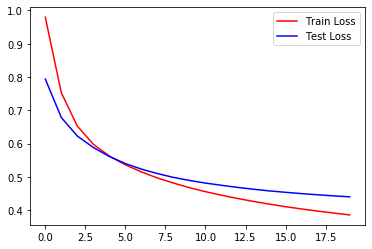

In [134]:
plt.plot(train_losses, "r", label="Train Loss")
plt.plot(test_losses, "b", label="Test Loss")
plt.legend()

Clearly, Our model is not generalized well. We may try with using dropout, larger trainsets, mini-batches to generalize our model well.

In [137]:
def predict(img_idx):
        img = testing_images[img_idx]
        label = testing_labels[img_idx].reshape((10, 1))

        layer_0 = img.reshape((input_image_depth, input_image_height, input_image_width))

        layer_1 = convolution(layer_0, kernel_1)
        layer_2, layer_2_1_0 = maxPool(layer_1, max_pool_size)
        layer_2 = tanh(layer_2)

        layer_2_flattened = layer_2.reshape((-1, 1))

        layer_3 = tanh(weight_layer_2_layer_3.T.dot(layer_2_flattened))


        final_output = weight_layer_3_output.T.dot(layer_3)
        plt.title("Actual: {} Predicted: {}".format(index_to_label_name[np.argmax(label)], index_to_label_name[np.argmax(final_output)]))
        plt.imshow(img.reshape((28,28)), cmap="gray")
    

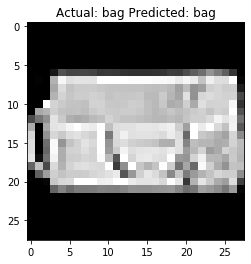

In [138]:
predict(img_idx = 30)

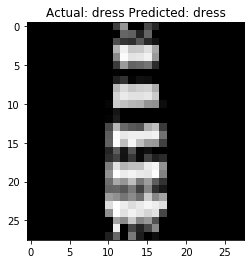

In [140]:
predict(img_idx = 19)

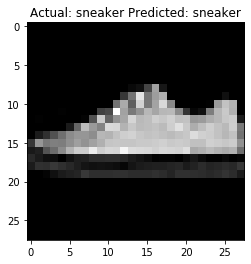

In [142]:
predict(img_idx = 76)

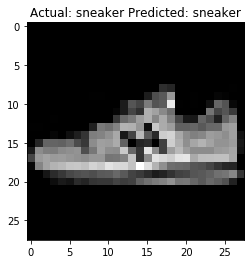

In [143]:
predict(img_idx = 43)

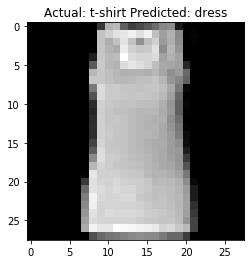

In [144]:
predict(img_idx = 72)